In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata

%matplotlib inline

In [2]:
#board = cv2.cvtColor(cv2.imread("dev_images/20201102_195508.jpg"), cv2.COLOR_BGR2RGB)
#corners = [(2568, 2769), (2074, 1984), (2975, 1686), (3750, 2294)]

board = cv2.cvtColor(cv2.imread("dev_images/20201102_195451.jpg"), cv2.COLOR_BGR2RGB)
corners = [ (1521, 672), (605, 1354), (1964, 2064), (2632, 1126)]

cy = [ pt[1] for pt in corners ] 
cx = [ pt[0] for pt in corners ]

# Find a rectangle the captures all these points and crop image
ox = np.min(cx)
oxw = np.max(cx) - ox
oy = np.min(cy)
oyh = np.max(cy) - oy

img_crop = board[oy:(oy+oyh),ox:(ox+oxw)].copy()

# Restate cx,cy in these terms
cy = [ y - oy for y in cy ]
cx = [ x - ox for x in cx ]

tile_res = 128

ideal = [ (5*tile_res, 5*tile_res), (0, 5*tile_res), (0, 0), (5*tile_res, 0) ]
ix = np.array([ pt[0] for pt in ideal ])
iy = np.array([ pt[1] for pt in ideal ])

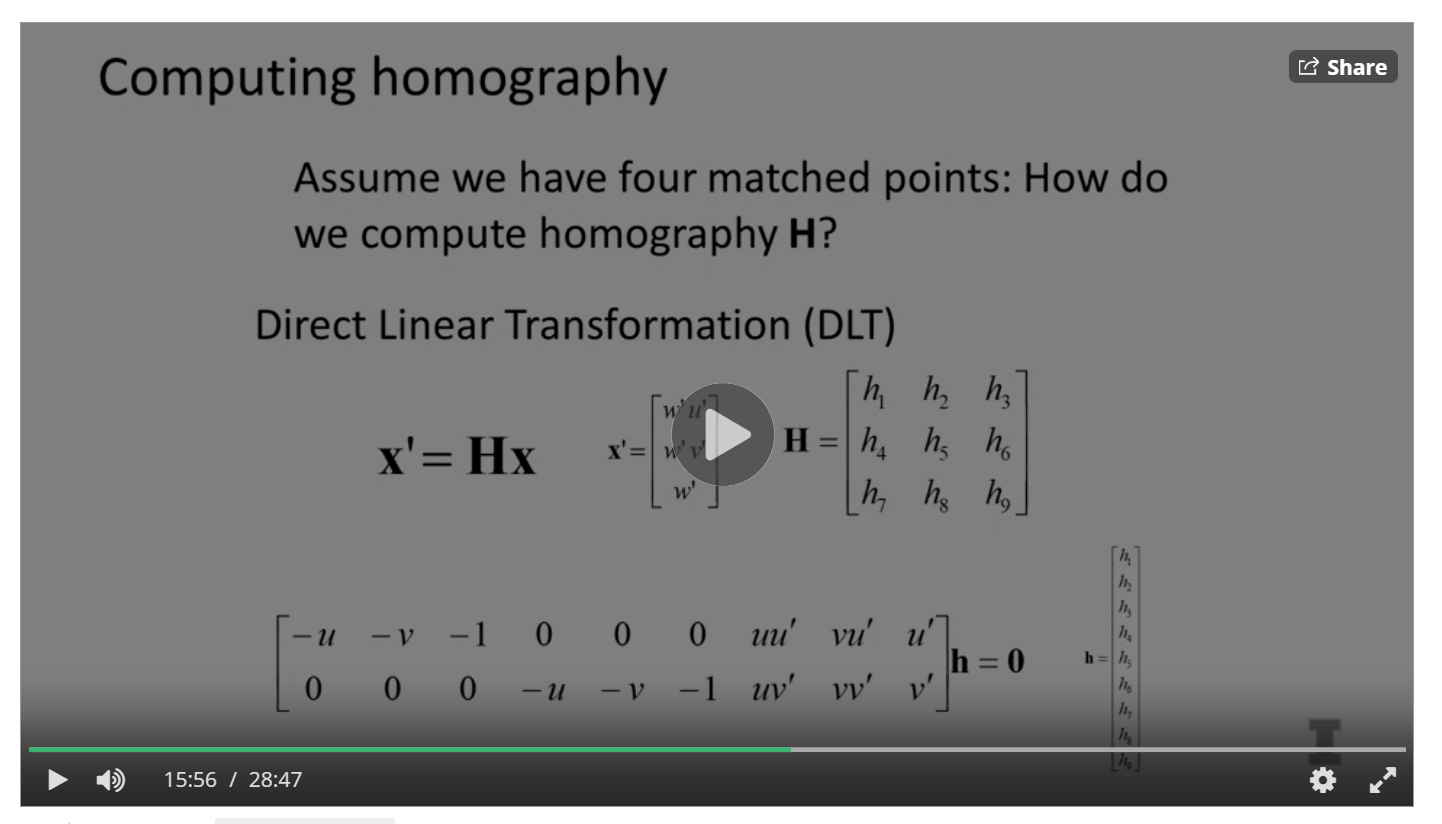

In [ ]:
# This setup follows 
# http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf

# the following setups mapping of rhombus identified above to a rectangle with corners (0,0) and (2,1)
T1 = np.array([
    [cx[0], cy[0], 1.,     0,     0,  0, -cx[0]*ix[0], -cy[0]*ix[0]],
    [    0,     0,  0, cx[0], cy[0],  1, -cx[0]*iy[0], -cy[0]*iy[0]],
    [cx[1], cy[1], 1.,     0,     0,  0, -cx[1]*ix[1], -cy[1]*ix[1]],
    [    0,     0,  0, cx[1], cy[1],  1, -cx[1]*iy[1], -cy[1]*iy[1]],
    [cx[2], cy[2], 1.,     0,     0,  0, -cx[2]*ix[2], -cy[2]*ix[2]],
    [    0,     0,  0, cx[2], cy[2],  1, -cx[2]*iy[2], -cy[2]*iy[2]],
    [cx[3], cy[3], 1.,     0,     0,  0, -cx[3]*ix[3], -cy[3]*ix[3]],
    [    0,     0,  0, cx[3], cy[3],  1, -cx[3]*iy[3], -cy[3]*iy[3]]])

c1 = np.array([ix[0], iy[0], ix[1], iy[1], ix[2], iy[2], ix[3], iy[3]])

est = np.linalg.solve(T1, c1)
A = np.array([
    [est[0], est[1], est[2]],
    [est[3], est[4], est[5]],
    [est[6], est[7], 1.0]])
Ainv = np.linalg.inv(A)


print(est)
print(A)
print(Ainv)

In [ ]:
for i in range(4):
    res = np.matmul(A, np.array([cx[i], cy[i], 1]))
    res = res / res[2]
    print(res)
    
for i in range(4):
    res = np.matmul(Ainv, np.array([ix[i], iy[i], 1]))
    res = res / res[2]
    print(res)

In [ ]:
print(cy)
print(cx)

In [ ]:
def invMap(xs, ys):
    txs = Ainv[0, 0]*xs + Ainv[0, 1]*ys + Ainv[0, 2]
    tys = Ainv[1, 0]*xs + Ainv[1, 1]*ys + Ainv[1, 2]
    hs = Ainv[2, 0]*xs + Ainv[2, 1]*ys + Ainv[2, 2]
    txs = txs / hs
    tys = tys / hs
    return txs, tys

In [ ]:
ys, xs = np.mgrid[0:(5*tile_res), 0:(5*tile_res)]
txs, tys = invMap(xs, ys)
old_grid_y, old_grid_x = np.mgrid[0:img_crop.shape[0], 0:img_crop.shape[1]]

In [ ]:
result = np.zeros((5*tile_res, 5*tile_res, 3))

for c in range(3):
    test = griddata(
        np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2),
        img_crop[:,:,c].T.flatten(),
        (txs, tys))
    result[:,:,c] = test

In [1]:
old_grid_x

NameError: name 'old_grid_x' is not defined

In [ ]:
t2 = result.astype('uint8')

In [ ]:
plt.imshow(t2)

In [ ]:
import TileUtility

HalfTiles = TileUtility.HalfTiles(TileUtility.FullTiles())

In [ ]:
for i in range(5):
    for j in range(5):
        tile = t2[128*i:128*(i+1), 128*j:128*(j+1)].copy()
        avg = np.mean(np.mean(tile, axis = 0), axis = 0)
        print("{0}, {1}, {2}".format(i, j, avg))
#        plt.figure()
#        plt.imshow(tile)
#        pt = HalfTiles.predictTerrain(tile)
#        pc = HalfTiles.predictCrowns(tile)
#        prob_tiles = HalfTiles.tileCandidates(tile)
        
#        print("{0}, {1} terrain:{2}  crowns:{3}  tiles:{4}".format(i, j, pt, pc, prob_tiles))

In [ ]:
def predictTerrain(image):
    """Returns a predicted terrain type for the given 128x128 image"""
    assert(image.shape[0:2] == (128, 128))
    ccenters = np.array([[161.48790095, 141.80672983, 10.09729473],
                [85.94123424,  93.49039529,  41.31753817],
                [74.23682319, 107.92738851, 138.87711249],
                [117.44718715, 137.31491961,  30.39860317],
                [124.87008057, 110.4710083,   65.12401123],
                [ 94.07957967,  81.18944295,  49.85673014]])
    avg = np.mean(np.mean(image, axis = 0), axis = 0)
    distance = np.sum((avg - ccenters)**2, axis = 1)
    guess = np.where(distance == np.min(distance))[0][0]
    return {
        "cluster_center": ccenters[guess],
        "avg": avg,
        "distance": distance,
        "guess": guess
    }

In [ ]:
def RGBBalance(board, bal):
    loss = 0
    for i in range(5):
        yl = tile_res*i
        yu = yl + tile_res
        for j in range(5):
            xl = tile_res*j
            xu = xl + tile_res
            tile = t2[yl:yu, xl:xu] * bal
            pt = predictTerrain(tile)
            loss = loss + min(pt["distance"])
    return loss

In [ ]:
RGBBalance(t2, np.array([1, 1, 1]))

In [ ]:
import scipy.optimize
sol = scipy.optimize.minimize(lambda x: RGBBalance(t2, x), np.array([1., 1., 1.]), method='BFGS', options={"maxiter": 100, 'gtol': 1e-6, 'disp': True})

In [ ]:
print(sol)

In [ ]:
t3 = (t2.copy() * sol.x).astype('uint8')

In [ ]:
tiles = {}
for i in range(5):
    tiles[i] = {}
    
    for j in range(5):
        tile = t3[128*i:128*(i+1), 128*j:128*(j+1)].copy()
        avg = np.mean(np.mean(tile, axis = 0), axis = 0)
#        plt.figure()
#        plt.imshow(tile)
        pt = HalfTiles.predictTerrain(tile)
        pc = HalfTiles.predictCrowns(tile)
        prob_tiles = HalfTiles.tileCandidates(tile)
        tiles[i][j] = set(prob_tiles)
        
        print("{0}, {1} terrain:{2}  crowns:{3}  tiles:{4}".format(i, j, pt, pc, prob_tiles))

In [ ]:
def findCrowns(image, thresh = 30, radius = 25):
    """Returns a list [(y, x, L), ...] of coordinates and associated loss of likely locations
    of crowns in the given image.

    thresh=30 is tuned to 128x128 may need adjustment for other sizes.
    radius=25 similarly tuned is used to eliminate candidate points that are close together.
    """
    loss = HalfTiles.crownLoss(image)
    idx = np.where(loss <= thresh)

    print(np.min(loss))
    
    # Remove idx that are close together. Use the lowest loss.
    def helper(ys, xs):
        clusters = []
        for y, x in zip(ys, xs):
            new_point = True
            # Will we add this to our list of candidate crowns?
            # calculate distance to other found centers.
            for i, (yr, xr, closs) in enumerate(clusters):
                distance = (yr - y)*(yr - y) + (xr - x)*(xr - x)
                if distance < 25:
                    new_point = False                
                    if loss[y, x] < closs:
                        # This new point is close and has a better loss, so replace it.
                        clusters[i] = (y, x, loss[y, x])

            # If new_point is still tru
            if new_point:
                clusters.append((y, x, loss[y, x]))
        return clusters

    clusters = helper(idx[0], idx[1])

    newys = [ c[0] for c in clusters ] 
    newxs = [ c[1] for c in clusters ]

    return helper(newys, newxs)

In [ ]:
i = 0
j = 0
tile = t3[128*i:128*(i+1), 128*j:128*(j+1)].copy()
k = 0
while (k < 4):
    test = findCrowns(tile, thresh=40)
    print(test)
    tile = np.rot90(tile)
    k = k + 1


In [ ]:
plt.imshow(t3.astype('uint8'))

In [ ]:
plt.imshow(t3.astype('uint8'))

In [ ]:
def findCrowns(self, image, thresh = 30, radius = 25):
    """Returns a list [(y, x, L), ...] of coordinates and associated loss of likely locations
    of crowns in the given image.

    thresh=30 is tuned to 128x128 may need adjustment for other sizes.
    radius=25 similarly tuned is used to eliminate candidate points that are close together.
    """
    loss = self.crownLoss(image)
    idx = np.where(loss <= thresh)

    # Remove idx that are close together. Use the lowest loss.
    def helper(ys, xs):
        clusters = []
        for y, x in zip(ys, xs):
            new_point = True
            # Will we add this to our list of candidate crowns?
            # calculate distance to other found centers.
            for i, (yr, xr, closs) in enumerate(clusters):
                distance = (yr - y)*(yr - y) + (xr - x)*(xr - x)
                if distance < 25:
                    new_point = False                
                    if loss[y, x] < closs:
                        # This new point is close and has a better loss, so replace it.
                        clusters[i] = (y, x, loss[y, x])

            # If new_point is still tru
            if new_point:
                clusters.append((y, x, loss[y, x]))
        return clusters
 
    clusters = helper(idx[0], idx[1])
    
    newys = [ c[0] for c in clusters ] 
    newxs = [ c[1] for c in clusters ]
    
    return helper(newys, newxs)

In [ ]:
findCrowns(HalfTiles, tile)

In [ ]:
def tileIntersection(L, R):
    if L is None or R is None: return []
    # Split off L and R from lists but
    LL = {}
    RR = {}
    
    for tile in L:
        t = tile.split("_")
        if t[0] in LL: LL[t[0]].append(t[1])
        else: LL[t[0]] = [t[1]]
        
    for tile in R:
        t = tile.split("_")
        if t[0] in RR: RR[t[0]].append(t[1])
        else: RR[t[0]] = [t[1]]

    candidates = []
    for tile, sides in LL.items():
        if tile in RR:
            for side in sides:
                if side == "L": opp = "R"
                else: opp = "L"

                if opp in RR[tile]: candidates.append(((tile, side), (tile, opp)))
    return sorted(candidates, key=lambda x: x[0])

matches = [ [ (False, set([])) for j in range(5) ] for i in range(5) ]
for i in range(5):
    for j in range(5):        
        if (i < 4): down = tiles[i + 1][j]
        else: down = None
            
        if (j < 4): right = tiles[i][j + 1]
        else: right = None

        matchesDown = tileIntersection(tiles[i][j], down)
        matchesRight = tileIntersection(tiles[i][j], right)
        
        for (m, n) in matchesDown:
            matches[i][j][1].add(m)
            matches[i + 1][j][1].add(n)
        for [m, n] in matchesRight:
            matches[i][j][1].add(m)
            matches[i][j + 1][1].add(n)

#for i in range(5):
#    for j in range(5):
#        matches[i][j] = list(matches[i][j])
            
row =       "|     | col0   | col1   | col2   | col3   | col4 |\n"
row = row + "| --- | --- | --- | --- | --- | --- | \n"
for i in range(5):
    row = row + "| " + "row " + str(i) + " | "
    for j in range(5):
        for tile, side in matches[i][j][1]:
            row = row + " " + tile + side
        row = row + " | "
    row = row + "\n"

display(Markdown(row))


In [ ]:
import copy

def fixMatch(matches, i, j, tile, iLeft):
    result = copy.deepcopy(matches)
    
    print("i={0}, j={1} tile={2}, iLeft={3}".format(i, j, tile, iLeft))
    assert(result[i[0]][i[1]][0] == False)
    assert(result[j[0]][j[1]][0] == False)
    
    if (iLeft):
        leftTile = tile + "_L"
        rightTile = tile + "_R"
    else:
        leftTile = tile + "_R"
        rightTile = tile + "_L"
    
    for R in range(5):
        for C in range(5):
            if not result[R][C][0]:
                if leftTile in result[R][C][1]: result[R][C][1].remove(leftTile)
                if rightTile in result[R][C][1]: result[R][C][1].remove(rightTile)

    result[i[0]][i[1]] = (True, leftTile)
    result[j[0]][j[1]] = (True, rightTile)
    
    return result

In [ ]:
# Try to simplify matches by looking for cells with a single option 
# and then searching neighbors for match.   If there is only a single match
#  that domino must be there.  Place it and remove other options.

def simplifyTiles1(matches):
    for i in range(5):
        for j in range(5):
            if not matches[i][j][0] and len(matches[i][j][1]) == 1:
                tile, side = next(iter(matches[i][j][1]))
                if side == 'L': opp = 'R'
                else: opp = 'L'

                otile = (tile, opp)

                #print("Found singleton at {0}, {1}, {2}.  Looking for {3}".format(i, j, (tile, side), otile))

                # Find neighbor tile
                match = 0
                #print(otile)
                if j < 4: print(matches[i][j + 1])
                if i > 0 and not matches[i - 1][j][0] and otile in matches[i - 1][j][1]: match += 8
                if i < 4 and not matches[i + 1][j][0] and otile in matches[i + 1][j][1]: match += 4
                if j > 0 and not matches[i][j - 1][0] and otile in matches[i][j - 1][1]: match += 2
                if j < 4 and not matches[i][j + 1][0] and otile in matches[i][j + 1][1]: match += 1
                #print("Otile {0} found {1}".format(otile, match))

                if match == 1:
                    return True, fixMatch(matches, (i, j), (i, j + 1), tile, side == 'L')
                elif match == 2:
                    return True, fixMatch(matches, (i, j), (i, j - 1), tile, side == 'L')               
                elif match == 4:
                    return True, fixMatch(matches, (i, j), (i + 1, j), tile, side == 'L')
                elif match == 8:
                    return True, fixMatch(matches, (i, j), (i - 1, j), tile, side == 'L')
    return False, matches

In [ ]:
nextIter = copy.deepcopy(matches)
while True:
    foundQ, nextIter = simplifyTiles(nextIter)
    if not foundQ: break
        

In [ ]:
row =       "|     | col0   | col1   | col2   | col3   | col4 |\n"
row = row + "| --- | --- | --- | --- | --- | --- | \n"
for i in range(5):
    row = row + "| " + "row " + str(i) + " | "
    for j in range(5):
        if not nextIter[i][j][0]:
            for tile, side in nextIter[i][j][1]:
                row = row + " " + tile + side
        else:
            row = row + " " + "{" + nextIter[i][j][1] + "}"
            
        row = row + " | "
    row = row + "\n"

display(Markdown(row))

In [ ]:
minClusters = []
minIdx = []

for i in range(5):
    for j in range(5):
        foo = predictTerrain(t2[128*i:128*(i+1),128*j:128*(j+1)])
        minClusters.append(np.min(foo["distance"]))
        minIdx.append((i,j))

print(np.max(minClusters))
print(np.where(minClusters == np.max(minClusters)))

In [ ]:
minClusters